In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
from adjustText import adjust_text
import random
from model_structure import get_preprocessing_transforms,BCNN, train_model, evaluate_model

In [17]:
INPUT_SIZE = 224
BATCH_SIZE=32
DEVICE = torch.device('cpu') # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
def read_data():
    # Get transforms
    train_transform, val_transform = get_preprocessing_transforms(INPUT_SIZE)

    test_data_1_dir = 'data4model_1/test/'
    test_data_2_dir = 'data4model_2/test/'
    train_data_1_dir = 'data4model_1/train/'
    train_data_2_dir = 'data4model_2/train/'

    # Load data set
    dataset_test_1 = datasets.ImageFolder(test_data_1_dir,transform=val_transform)
    dataset_train_1 = datasets.ImageFolder(train_data_1_dir,transform=train_transform)
    dataset_test_2 = datasets.ImageFolder(test_data_2_dir,transform=val_transform)
    dataset_train_2 = datasets.ImageFolder(train_data_2_dir,transform=train_transform)

    test_loader_1 = DataLoader(dataset_test_1, shuffle=False, batch_size=BATCH_SIZE)
    train_loader_1 = DataLoader(dataset_train_1, shuffle=False, batch_size=BATCH_SIZE)
    test_loader_2 = DataLoader(dataset_test_2, shuffle=False, batch_size=BATCH_SIZE)
    train_loader_2 = DataLoader(dataset_train_2, shuffle=False, batch_size=BATCH_SIZE)

    return {"Model_1:Train": train_loader_1,
            "Model_1:Test": test_loader_1,
            "Model_2:Train": train_loader_2,
            "Model_2:Test": test_loader_2}

In [19]:
model_1_dir = 'best_model_1.pth'
model_2_dir = 'best_model_2.pth'

In [20]:
# Load the model
model_1 = BCNN().to(DEVICE)
weights = torch.load(model_1_dir, map_location=torch.device(DEVICE))
model_1.load_state_dict(weights)
model_1.eval()

model_2 = BCNN().to(DEVICE)
weights = torch.load(model_2_dir, map_location=torch.device(DEVICE))
model_2.load_state_dict(weights)
model_2.eval()

C:\Users\hskay\AppData\Local\Temp\ipykernel_13468\1438434258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_1_dir, map_location=torch.device(

BCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigm

In [21]:
dataSets = read_data()

In [22]:
for key in dataSets:
    print(key)
    if "Model_1" in key:
        model = model_1
    else:
        model = model_2
    
    results = evaluate_model(model.to(DEVICE), dataSets[key], DEVICE)
    print("Accuracy: ", results[0])
    print("F1 Score: ", results[1])
    print("confusion Matrix: \n",results[3])
    print("\n")

Model_1:Train
Accuracy:  0.9203333333333333
F1 Score:  0.919501515661839
confusion Matrix: 
 [[1396  104]
 [ 135 1365]]


Model_1:Test
Accuracy:  0.875
F1 Score:  0.8743718592964824
confusion Matrix: 
 [[88 12]
 [13 87]]


Model_2:Train
Accuracy:  0.899
F1 Score:  0.8966928060006819
confusion Matrix: 
 [[1382  118]
 [ 185 1315]]


Model_2:Test
Accuracy:  0.905
F1 Score:  0.9090909090909091
confusion Matrix: 
 [[86 14]
 [ 5 95]]




In [183]:
N_NEURONS = 15  # Number of random neurons to monitor
activation_values = {}

In [184]:
for i,j in model_1.named_modules():
    if isinstance(j, (nn.ReLU)):
        print(j)
        print("*")
        a = j
        break

ReLU(inplace=True)
*


In [185]:
def get_activation(name):
    def hook(model, input, output):
        activation_values[name] = output.detach()
    return hook

def register_hooks(model, N=1):
    hooks = []
    layer_info = {}
    # layer_names = [
    # 'conv1','relu1','pool1','dropout1','conv2','relu2','pool2', 'dropout2','conv3','relu3','pool3','dropout3', 
    # 'flatten','fc1','relu4','dropout4''fc2','sigmoid']
    for name, layer in model.named_modules():
        #if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Register hook for the full layer output
            hooks.append(layer.register_forward_hook(get_activation(name)))
            
            # Store layer information
            if isinstance(layer, nn.Linear): # Linear layer
                layer_info[name] = {
                    'type': 'linear',
                    #'neurons': layer.out_features
                }
            else: # Convolutional layer
                layer_info[name] = {
                    'type': 'conv',
                    # 'neurons': layer.out_channels
                }
    return hooks, layer_info

# Function to select random neurons from activations
def select_random_neurons(activations, layer_info, n_neurons=1):
    data = {}
    
    for layer_name, layer_data in layer_info.items():
        activation = activations[layer_name]

        if layer_data['type'] == 'conv':  # (batch, channels, height, width)
            flattened = activation.view(activation.shape[0],-1)
            n_features = flattened.shape[1]
            selected_indices = random.sample(range(n_features), min(n_neurons, n_features))
            selected_indices, selected_activations = selected_indices, flattened[:, selected_indices]
        else:  # linear layer (batch, features)
            n_features = activation.shape[1]
            selected_indices = random.sample(range(n_features), min(n_neurons, n_features))
            selected_indices, selected_activations = selected_indices, activation[:, selected_indices]
        
        data[layer_name]={
            'neuron_idx': selected_indices,
            'activation': selected_activations}
    
    return data

# Function to process and save activations
def save_activations_to_csv(layer_info, model_name, permutation, pic_index, n_neurons=1):
    data = []
    
    for layer_name, layer_data in layer_info.items():
        # Select random neurons
        selected_indices, selected_activations = permutation[layer_name]['neuron_idx'], permutation[layer_name]['activation']
        
        # Convert to numpy and process each selected neuron
        activation_np = selected_activations.cpu().numpy()
        
        for idx, neuron_idx in enumerate(selected_indices):
            value = activation_np[0, idx]  # Take first batch
            data.append({
                'model': model_name,
                'data_idx': pic_index,
                'layer': layer_name,
                'neuron_idx': neuron_idx,
                'activation': value,
                'layer_type': layer_data['type']
            })
    

    df = pd.DataFrame(data)
    df.to_csv(f'{model_name}_layer_neuron_activations.csv', index=False)
    return df

def plot_layer_neuron_activations(df, model_name):
    plt.figure(figsize=(15, 8))
    
    # Convert layer names to numeric indices
    unique_layers = df['layer'].unique()
    layer_to_index = {layer: idx for idx, layer in enumerate(unique_layers)}
    df['layer_idx'] = df['layer'].map(layer_to_index)
    
    df_sorted = df.sort_values(['layer_idx', 'neuron_idx'])
    
    # Calculate vertical offset for annotations
    def get_offset(idx, total):
        if total == 1:
            return 0
        return (idx - (total-1)/2) * 0.4  # Adjust 0.4 to control vertical spacing
    
    # Group by layer to handle overlapping within each layer
    for layer in df_sorted['layer'].unique():
        layer_data = df_sorted[df_sorted['layer'] == layer]
        n_points = len(layer_data)
        
        # Create scatter plot
        scatter = plt.scatter(layer_data['layer'], 
                            layer_data['neuron_idx'],
                            s=layer_data['activation'] * 500 + 100,
                            alpha=1,
                            c=layer_data['activation'],
                            cmap='viridis',
                            zorder=2)
        
        # Add annotations with calculated offsets
        for idx, (_, row) in enumerate(layer_data.iterrows()):
            act_value = f"{row['activation']:.3f}"
            annotation = f"n{row['neuron_idx']}\n({act_value})"
            
            offset = get_offset(idx, n_points)
            
            plt.annotate(annotation,
                        (row['layer'], row['neuron_idx']),
                        xytext=(20, offset * 50),  # Adjust horizontal and vertical offset
                        textcoords='offset points',
                        fontsize=8,
                        bbox=dict(facecolor='white', 
                                edgecolor='none', 
                                alpha=0.7),
                        arrowprops=dict(arrowstyle='->', 
                                      color='gray',
                                      alpha=0.5),
                        zorder=3)
    
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Layer Name')
    plt.ylabel('Neuron Index')
    plt.title(f'{model_name} - Layer Neuron Activations')
    
    plt.colorbar(scatter, label='Activation Value')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

In [186]:
hooks1, layers1 = register_hooks(model_1, N_NEURONS)
hooks2, layers2 = register_hooks(model_2, N_NEURONS)

In [187]:
# Taking a data which is dog
images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:Test"].dataset) 
            if label == 1]

In [188]:
img, pic_index = random.choice(images)

In [189]:
with torch.no_grad():
    pred1 = model_1(img.unsqueeze(0).to(DEVICE))
    pred2 = model_2(img.unsqueeze(0).to(DEVICE))

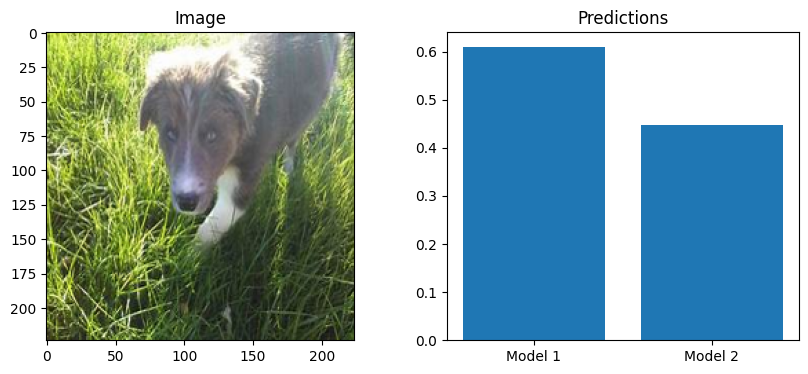

In [190]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title('Image')

plt.subplot(1, 2, 2)
plt.bar(['Model 1', 'Model 2'], 
        [pred1.item(), pred2.item()])
plt.title('Predictions')
plt.show()

In [196]:
permutation = select_random_neurons(activation_values, layers1, N_NEURONS)
df1= save_activations_to_csv(layers1, 'model1',permutation, pic_index,  N_NEURONS)
df2 = save_activations_to_csv(layers2, 'model2',permutation,pic_index, N_NEURONS)
# Plot activations for both models
plot_layer_neuron_activations(df1, 'Model 1')
plot_layer_neuron_activations(df2, 'Model 2')


C:\Users\hskay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


ValueError: need at least one array to concatenate

<Figure size 1500x800 with 2 Axes>

C:\Users\hskay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


ValueError: need at least one array to concatenate

<Figure size 1500x800 with 2 Axes>

In [192]:
df1

,model,data_idx,layer,neuron_idx,activation,layer_type,layer_idx
0,model1,146,,0,0.447510,conv,0
1,model1,146,features,90502,0.000000,conv,1
2,model1,146,features,67327,0.000000,conv,1
3,model1,146,features,23476,0.000000,conv,1
4,model1,146,features,65857,0.000000,conv,1
...,...,...,...,...,...,...,...
254,model1,146,classifier.3,16,0.000000,conv,18
255,model1,146,classifier.3,337,0.000000,conv,18
256,model1,146,classifier.3,116,0.000000,conv,18
257,model1,146,classifier.4,0,-0.210738,linear,19


In [193]:
df = df1
plt.figure(figsize=(15, 8))  # Increased figure size for better label visibility
    
# Convert layer names to numeric indices for line plotting
unique_layers = df['layer'].unique()
layer_to_index = {layer: idx for idx, layer in enumerate(unique_layers)}
df['layer_idx'] = df['layer'].map(layer_to_index)

# Sort by layer index and neuron index for proper line connections
df_sorted = df.sort_values(['layer_idx', 'neuron_idx'])
for neuron_idx in range(N_NEURONS):
        neuron_data = df_sorted[df_sorted['neuron_idx'] == df_sorted['neuron_idx'].unique()[neuron_idx]]  
        print(neuron_data)
        print()  

      model  data_idx         layer  neuron_idx  activation layer_type  \
0    model1       146                         0    0.447510       conv   
196  model1       146    classifier           0    0.447510       conv   
257  model1       146  classifier.4           0   -0.210738     linear   
258  model1       146  classifier.5           0    0.447510       conv   

     layer_idx  
0            0  
196         14  
257         19  
258         20  

     model  data_idx     layer  neuron_idx  activation layer_type  layer_idx
11  model1       146  features        9593         0.0       conv          1

    model  data_idx     layer  neuron_idx  activation layer_type  layer_idx
8  model1       146  features       21887         0.0       conv          1

    model  data_idx     layer  neuron_idx  activation layer_type  layer_idx
3  model1       146  features       23476         0.0       conv          1

    model  data_idx     layer  neuron_idx  activation layer_type  layer_idx
7  mod

<Figure size 1500x800 with 0 Axes>

In [194]:
df_sorted

,model,data_idx,layer,neuron_idx,activation,layer_type,layer_idx
0,model1,146,,0,0.447510,conv,0
11,model1,146,features,9593,0.000000,conv,1
8,model1,146,features,21887,0.000000,conv,1
3,model1,146,features,23476,0.000000,conv,1
7,model1,146,features,30514,0.000000,conv,1
...,...,...,...,...,...,...,...
252,model1,146,classifier.3,361,0.000000,conv,18
253,model1,146,classifier.3,371,0.000000,conv,18
247,model1,146,classifier.3,409,0.191031,conv,18
257,model1,146,classifier.4,0,-0.210738,linear,19


In [195]:

# Remove hooks
for hook in hooks1 + hooks2:
    hook.remove()